# A case study on police behavior during traffic stops with pandas

## Purpose and contextualization

In this notebook, we'll walk along a journey exploring part of the Stanford Open Policing Project dataset and analyze the impact of gender, hour of day, weather and many other variables on police behavior during traffic stops. This notebook is aimed for you who wants to gain more practice cleaning messy data, creating visualizations, combining and reshaping datasets, and manipulating time series data with the pandas library.

The original dataset has data collected in 31 US states. By simplicity we will use only the data for the Rhode Island state, as it is enough to make our point here. You can download the full dataset for anyone of the 31 states [here](https://openpolicing.stanford.edu/).

Also, these notes are fully based in the [datacamp](https://www.datacamp.com/) course: [Analyzing Police activity with pandas](https://www.datacamp.com/courses/analyzing-police-activity-with-pandas). I give all credits to the datacamp team.

In [1]:
import pandas as pd

In [2]:
# You must change this path in order to load the data from your computer into the notebook

path_name = r'C:\Users\alexa\Documents\Analyzing Police Activity with pandas\datasets\Traffic stops in Rhode Island.csv'
ri = pd.read_csv(path_name)

# 1. Exploratory Data Analysis and Dataset preprocessing

In [3]:
ri.head()

,state,stop_date,stop_time,county_name,driver_gender,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district
0,RI,2005-01-04,12:55,NaN,M,White,Equipment/Inspection Violation,Equipment,False,NaN,Citation,False,0-15 Min,False,Zone X4
1,RI,2005-01-23,23:15,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3
2,RI,2005-02-17,04:15,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4
3,RI,2005-02-20,17:15,NaN,M,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False,Zone X1
4,RI,2005-02-24,01:20,NaN,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X3


In [4]:
print('The dataset shape has ' + str(ri.shape[0]) + ' records and ' + str(ri.shape[1]) + ' columns.')

The dataset shape has 91741 records and 15 columns.


In [5]:
ri.isnull().sum()

state                     0
stop_date                 0
stop_time                 0
county_name           91741
driver_gender          5205
driver_race            5202
violation_raw          5202
violation              5202
search_conducted          0
search_type           88434
stop_outcome           5202
is_arrested            5202
stop_duration          5202
drugs_related_stop        0
district                  0
dtype: int64

Often, a DataFrame will contain columns that are not useful to your analysis. Such columns should be dropped from the DataFrame, to make it easier for you to focus on the remaining columns.

As it is the case, have a look in the shape of the dataframe and see that the column 'county_name' has as many NaN values as possible, implying that this column can be dropped without any loss of information to the dataset. On the other hand, as we are examining the data only for the state of Rhode Island, we can also drop the column 'state' from the dataset.

In [6]:
ri.drop(['county_name','state'], axis='columns', inplace=True)

We will focus our analysis in the activity of policies between the two genders, considering this approach the column 'driver_gender' is critical for us. Therefore, all records that have null values for this column must be dropped for it will not contribute to our study of the dataset here.

In [7]:
ri.dropna(subset=['driver_gender'], inplace=True)

In [8]:
print('The new dataset shape is ' + str(ri.shape[0]) + ' records and ' + str(ri.shape[1]) + ' columns.')

The new dataset shape is 86536 records and 13 columns.


Now that we have only useful records let's check the datatypes of our DataFrame.

In [9]:
ri.dtypes

stop_date             object
stop_time             object
driver_gender         object
driver_race           object
violation_raw         object
violation             object
search_conducted        bool
search_type           object
stop_outcome          object
is_arrested           object
stop_duration         object
drugs_related_stop      bool
district              object
dtype: object

See that the DataFrame has many columns with the object type. This is not recommended as such type consumes more memory and affects the computational efficiency of our code. In addition, some mathematical operations can not be applied to the object type.

Besides, columns such as 'stop_date' and 'stop_time' are better represented as a datetime object, which will allows us to perform some operations in the records of these columns.

Currently, the date and time of each traffic stop are stored in separate object columns: stop_date and stop_time. In the next steps we will combine these two columns, modify its type as datetime and lastly set it as the DataFrame index.

In [10]:
# First of all, let's set the right type to the 'is_arrested' column
ri['is_arrested'] = ri.is_arrested.astype('bool')

In [11]:
combined = ri.stop_date.str.cat(ri.stop_time, sep=' ')
ri['stop_datetime'] = pd.to_datetime(combined)

In [12]:
ri.set_index('stop_datetime', inplace=True)
print(ri.index)

DatetimeIndex(['2005-01-04 12:55:00', '2005-01-23 23:15:00',
               '2005-02-17 04:15:00', '2005-02-20 17:15:00',
               '2005-02-24 01:20:00', '2005-03-14 10:00:00',
               '2005-03-29 21:55:00', '2005-04-04 21:25:00',
               '2005-07-14 11:20:00', '2005-07-14 19:55:00',
               ...
               '2015-12-31 13:23:00', '2015-12-31 18:59:00',
               '2015-12-31 19:13:00', '2015-12-31 20:20:00',
               '2015-12-31 20:50:00', '2015-12-31 21:21:00',
               '2015-12-31 21:59:00', '2015-12-31 22:04:00',
               '2015-12-31 22:09:00', '2015-12-31 22:47:00'],
              dtype='datetime64[ns]', name='stop_datetime', length=86536, freq=None)


# 2. A Comparison between genders

## 2.1 Do the genders commit different violations?

Before comparing the violations being committed by each gender, we are going to examine the violations committed by all drivers to get a baseline understanding of the data.

In [13]:
print(ri.violation.value_counts())

Speeding               48423
Moving violation       16224
Equipment              10921
Other                   4409
Registration/plates     3703
Seat belt               2856
Name: violation, dtype: int64


In [14]:
print(ri.violation.value_counts(normalize=True))

Speeding               0.559571
Moving violation       0.187483
Equipment              0.126202
Other                  0.050950
Registration/plates    0.042791
Seat belt              0.033004
Name: violation, dtype: float64


As we are trying to answer the question whether a gender commits different violations then the other, we will divide our preprocessed DataFrame into two other, one for each gender and analyze the violations separately.

In [15]:
# Create a DataFrame of female drivers
female = ri[ri.driver_gender == 'F']

# Create a DataFrame of male drivers
male = ri[ri.driver_gender == 'M']

In [16]:
# Compute the violations by female drivers (as proportions)
print(female.violation.value_counts(normalize=True))

Speeding               0.658114
Moving violation       0.138218
Equipment              0.105199
Registration/plates    0.044418
Other                  0.029738
Seat belt              0.024312
Name: violation, dtype: float64


In [17]:
# Compute the violations by male drivers (as proportions)
print(male.violation.value_counts(normalize=True))

Speeding               0.522243
Moving violation       0.206144
Equipment              0.134158
Other                  0.058985
Registration/plates    0.042175
Seat belt              0.036296
Name: violation, dtype: float64


Almost two-thirds of the violations for the female gender is for speeding while for the male gender, violations are more balanced among the classes. This does not implies that females speed more than males, as we are not taking into account the number of stops or drivers.

## 2.2 Does gender affect who gets a ticket for speeding?

When a driver is pulled over for speeding, many people believe that gender has an impact on whether the driver will receive a ticket or a warning. Let's find evidence exploring the dataset!

First, we'll create two DataFrames of drivers who were stopped for speeding: one containing females and the other containing males. Then, for each gender, we'll use the 'stop_outcome' column to calculate what percentage of stops resulted in a "Citation" (meaning a ticket) versus a "Warning".

In [18]:
# Create a DataFrame of female drivers stopped for speeding
female_and_speeding = ri[(ri.driver_gender == 'F') & (ri.violation == 'Speeding')]

# Create a DataFrame of male drivers stopped for speeding
male_and_speeding = ri[(ri.driver_gender == 'M') & (ri.violation == 'Speeding')]

In [19]:
# Compute the stop outcomes for female drivers (as proportions)
print(female_and_speeding.stop_outcome.value_counts(normalize=True))

Citation            0.952192
Warning             0.040074
Arrest Driver       0.005752
N/D                 0.000959
Arrest Passenger    0.000639
No Action           0.000383
Name: stop_outcome, dtype: float64


In [20]:
# Compute the stop outcomes for male drivers (as proportions)
print(male_and_speeding.stop_outcome.value_counts(normalize=True))

Citation            0.944595
Warning             0.036184
Arrest Driver       0.015895
Arrest Passenger    0.001281
No Action           0.001068
N/D                 0.000976
Name: stop_outcome, dtype: float64


The curious thing here is that the numbers are similar for both males and females. About 95% of stops for speeding result in a ticket. We then conclude that the data fails to show that gender has an impact on who gets a ticket for speeding.

## 2.3 Does gender affect whose vehicle is searched?

During a traffic stop, the police officer sometimes conducts a search of the vehicle. In the next step we'll calculate the percentage of all stops that result in a vehicle search, also knows as the search rate. 

After, we'll calculate the search rate for each gender separately.

In [21]:
# Calculate the search rate by counting the values
print("The search rate is about %4.3f percent" % (100*float(ri.search_conducted.value_counts(normalize=True)[1])))

The search rate is about 3.822 percent


In [22]:
# Calculate the search rate for female drivers
print("The search rate for female drivers is about %4.3f percent" % (100*float(ri[ri.driver_gender == 'F'].search_conducted.mean())))

The search rate for female drivers is about 1.918 percent


In [23]:
# Calculate the search rate for female drivers
print("The search rate for male drivers is about %4.3f percent" % (100*float(ri[ri.driver_gender == 'M'].search_conducted.mean())))

The search rate for male drivers is about 4.543 percent


In [24]:
# One could perform the same calculations using the groupby method as follows:
print(ri.groupby('driver_gender').search_conducted.mean())

driver_gender
F    0.019181
M    0.045426
Name: search_conducted, dtype: float64


 Male drivers are searched more than twice as often as female drivers. Why might this be?
 
Even though the search rate for males is much higher than for females, it's possible that the difference is mostly due to a second factor.

For example, you might hypothesize that the search rate varies by violation type, and the difference in search rate between males and females is because they tend to commit different violations.

We can test this hypothesis by examining the search rate for each combination of gender and violation. If the hypothesis was true, we would find that males and females are searched at about the same rate for each violation. Find out below if that's the case!

In [25]:
# Calculate the search rate for each combination of gender and violation
print(ri.groupby(['driver_gender','violation']).search_conducted.mean())

driver_gender  violation          
F              Equipment              0.039984
               Moving violation       0.039257
               Other                  0.041018
               Registration/plates    0.054924
               Seat belt              0.017301
               Speeding               0.008309
M              Equipment              0.071496
               Moving violation       0.061524
               Other                  0.046191
               Registration/plates    0.108802
               Seat belt              0.035119
               Speeding               0.027885
Name: search_conducted, dtype: float64


In [26]:
# Reverse the ordering to group by violation before gender
print(ri.groupby(['violation','driver_gender']).search_conducted.mean())

violation            driver_gender
Equipment            F                0.039984
                     M                0.071496
Moving violation     F                0.039257
                     M                0.061524
Other                F                0.041018
                     M                0.046191
Registration/plates  F                0.054924
                     M                0.108802
Seat belt            F                0.017301
                     M                0.035119
Speeding             F                0.008309
                     M                0.027885
Name: search_conducted, dtype: float64


For all types of violations, the search rate is higher for males than for females, disproving our hypothesis.

## 2.4 Does gender affect who is frisked during a search?

During a vehicle search, the police officer may pat down the driver to check if they have a weapon. This is known as a "protective frisk". At this time, we'll first check to see how many times "Protective Frisk" was the only search type. Then, we'll use a string method to locate all instances in which the driver was frisked.

In [27]:
# Count the 'search_type' values
print(ri.search_type.value_counts())

# Check if 'search_type' contains the string 'Protective Frisk'
ri['frisk'] = ri.search_type.str.contains('Protective Frisk', na=False)

# Take the sum of 'frisk'
print(ri.frisk.sum())

Incident to Arrest                                          1290
Probable Cause                                               924
Inventory                                                    219
Reasonable Suspicion                                         214
Protective Frisk                                             164
Incident to Arrest,Inventory                                 123
Incident to Arrest,Probable Cause                            100
Probable Cause,Reasonable Suspicion                           54
Probable Cause,Protective Frisk                               35
Incident to Arrest,Inventory,Probable Cause                   35
Incident to Arrest,Protective Frisk                           33
Inventory,Probable Cause                                      25
Protective Frisk,Reasonable Suspicion                         19
Incident to Arrest,Inventory,Protective Frisk                 18
Incident to Arrest,Probable Cause,Protective Frisk            13
Inventory,Protective Fris

It looks like there were 303 drivers who were frisked. Next, we'll examine whether gender affects who is frisked.

In [28]:
# Create a DataFrame of stops in which a search was conducted
searched = ri[ri.search_conducted == True]

# Calculate the overall frisk rate by taking the mean of 'frisk'
print(searched.frisk.mean())

0.09162382824312065


In [29]:
# Calculate the frisk rate for each gender
print(searched.groupby('driver_gender').frisk.mean())

driver_gender
F    0.074561
M    0.094353
Name: frisk, dtype: float64


Interesting! The frisk rate is higher for males than for females, though we can't conclude that this difference is caused by the driver's gender.

# 3. Arrests, violations and some plots

## 3.1 Does time of day affect arrest rate?

When a police officer stops a driver, a small percentage of those stops ends in an arrest. This is known as the arrest rate. At this time, we'll find out whether the arrest rate varies by time of day.

First, we'll calculate the arrest rate across all stops. Then, we'll calculate the hourly arrest rate by using the hour attribute of the index. 

In [30]:
# Calculate the overall arrest rate
print(ri.is_arrested.mean())

# Calculate the hourly arrest rate
print(ri.groupby(ri.index.hour).is_arrested.mean())

# Save the hourly arrest rate
hourly_arrest_rate = ri.groupby(ri.index.hour).is_arrested.mean()

0.0355690117407784
stop_datetime
0     0.051431
1     0.064932
2     0.060798
3     0.060549
4     0.048000
5     0.042781
6     0.013813
7     0.013032
8     0.021854
9     0.025206
10    0.028213
11    0.028897
12    0.037399
13    0.030776
14    0.030605
15    0.030679
16    0.035281
17    0.040619
18    0.038204
19    0.032245
20    0.038107
21    0.064541
22    0.048666
23    0.047592
Name: is_arrested, dtype: float64


In [31]:
# Import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Create a line plot of 'hourly_arrest_rate'
hourly_arrest_rate.plot()

# Add the xlabel, ylabel, and title
plt.xlabel('Hour')
plt.ylabel('Arrest Rate')
plt.title("Arrest Rate by Time of Day")

Text(0.5, 1.0, 'Arrest Rate by Time of Day')

 The graph shows that the arrest rate has a significant spike overnight, and then dips in the early morning hours.

## 3.2 Are drug-related stops on the rise?

In a small portion of traffic stops, drugs are found in the vehicle during a search. In this subsection, we'll assess whether these drug-related stops are becoming more common over time.

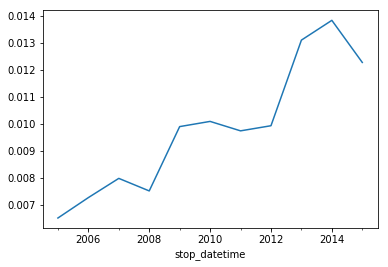

In [32]:
# Calculate the annual rate of drug-related stops
# print(ri.drugs_related_stop.resample('A').mean())

# Save the annual rate of drug-related stops
annual_drug_rate = ri.drugs_related_stop.resample('A').mean()

# Create a line plot of 'annual_drug_rate'
annual_drug_rate.plot()

The result if more than interesting. Have a look at how the rate of drug-related stops nearly doubled over the course of 10 years. Why might that be the case?

As we saw in the plot, the rate of drug-related stops increased significantly between 2005 and 2015. You might hypothesize that the rate of vehicle searches was also increasing, which would have led to an increase in drug-related stops even if more drivers were not carrying drugs.

We can test this hypothesis by calculating the annual search rate, and then plotting it against the annual drug rate. If the hypothesis is true, then we'll see both rates increasing over time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000124CB45B390>,
      dtype=object)

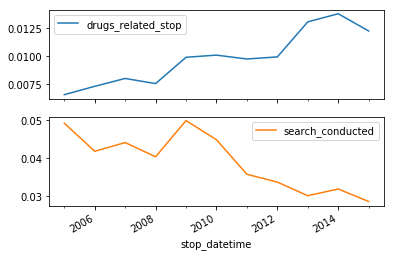

In [33]:
# Calculate and save the annual search rate
annual_search_rate = ri.search_conducted.resample('A').mean()

# Concatenate 'annual_drug_rate' and 'annual_search_rate'
annual = pd.concat([annual_drug_rate, annual_search_rate], axis='columns')

# Create subplots from 'annual'
annual.plot(subplots=True)

The rate of drug-related stops increased even though the search rate decreased, disproving our hypothesis.

## 3.3 What violations are caught in each district?

The state of Rhode Island is broken into six police districts, also known as zones. How do the zones compare in terms of what violations are caught by police?

In this subsection, we'll create a frequency table to determine how many violations of each type took place in each of the six zones. Then, we'll filter the table to focus on the "K" zones, which we'll examine further in this notebook.

In [34]:
# Save the frequency table as 'all_zones'
all_zones = pd.crosstab(ri.district,ri.violation)

# Select rows 'Zone K1' through 'Zone K3'
print(all_zones.loc['Zone K1':'Zone K3'])

# Save the smaller table as 'k_zones'
k_zones = all_zones.loc['Zone K1':'Zone K3']

violation  Equipment  Moving violation  Other  Registration/plates  Seat belt  \
district                                                                        
Zone K1          672              1254    290                  120          0   
Zone K2         2061              2962    942                  768        481   
Zone K3         2302              2898    705                  695        638   

violation  Speeding  
district             
Zone K1        5960  
Zone K2       10448  
Zone K3       12322  


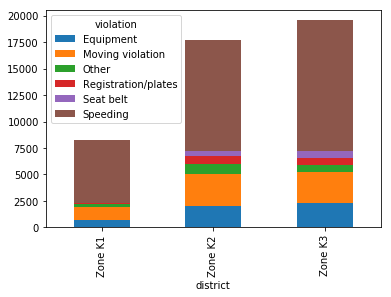

In [35]:
# Create a stacked bar plot of 'k_zones'
k_zones.plot(kind='bar', stacked=True)

This last bar plot shows that the vast majority of traffic stops in Zone K1 are for speeding, and Zones K2 and K3 are remarkably similar to one another in terms of violations.

## 3.4 How long might you be stopped for a violation

At this subsection we wish to analyze how long the driver was detained by the officer during a stop. Unfortunately, the durations are stored as strings. Therefore, before analyze any data, we must conform it to an appropriate type. 

To achieve this goal, we'll do a mapping such as follows:

Convert '0-15 Min' to 8. 
Convert '16-30 Min' to 23. 
Convert '30+ Min' to 45

In [36]:
# Create a dictionary that maps strings to integers
mapping = {'0-15 Min':8, '16-30 Min':23, '30+ Min':45}

# Convert the 'stop_duration' strings to integers using the 'mapping'
ri['stop_minutes'] = ri.stop_duration.map(mapping)

# Print the unique values in 'stop_minutes'
# print(ri.stop_minutes.unique())

If you were stopped for a particular violation, how long might you expect to be detained?

Now we'll visualize the average length of time drivers are stopped for each type of violation.

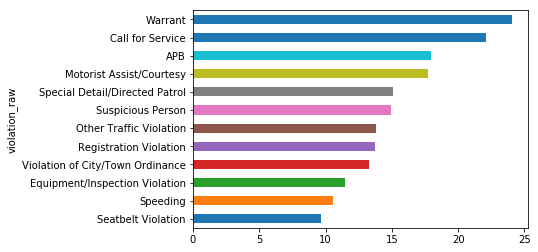

In [37]:
# Calculate the mean 'stop_minutes' for each value in 'violation_raw'
# print(ri.groupby('violation_raw').stop_minutes.mean())

# Save the resulting Series as 'stop_length'
stop_length = ri.groupby('violation_raw').stop_minutes.mean()

# Sort 'stop_length' by its values and create a horizontal bar plot
stop_length.sort_values().plot(kind='barh')

In this last plot, we can clearly visualize what sorts of violation results in a longer time detained by the officer.

# 4. How does weather influences police activity?

In this section, we'll be working with a new dataset to help us determine if weather conditions have an impact on police behavior.

The weather data we'll be using was collected by the National Centers for Environmental Information (NOAA). Ideally, we would look up the historical weather at the location of each stop. However, the traffic stops dataset does not specify stop location. So we're going to use the data from a single weather station near the center of Rhode Island.

This is not ideal, but Rhode Island is the smallest US state and so a station will give us a general idea of the weather throughout the state.

## 4.1 Assessing the reliability of the dataset

In [38]:
path_name_weather = r'C:\Users\alexa\Documents\Analyzing Police Activity with pandas\datasets\Weather in Providence, Rhode Island.csv'
weather = pd.read_csv(path_name_weather)

In [39]:
weather.head()

,STATION,DATE,TAVG,TMIN,TMAX,AWND,WSF2,WT01,WT02,WT03,...,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22
0,USW00014765,2005-01-01,44.0,35,53,8.95,25.1,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00014765,2005-01-02,36.0,28,44,9.40,14.1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
2,USW00014765,2005-01-03,49.0,44,53,6.93,17.0,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,USW00014765,2005-01-04,42.0,39,45,6.93,16.1,1.0,NaN,NaN,...,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,USW00014765,2005-01-05,36.0,28,43,7.83,17.0,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN


Let's check quickly if this dataset is a reliable source by plotting a boxplot of the temperature data.

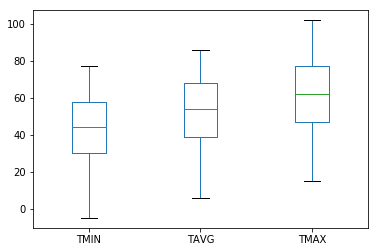

In [40]:
# Create a box plot of the temperature columns
weather[['TMIN','TAVG','TMAX']].plot(kind='box')

The temperature data looks good so far: the TAVG values are in between TMIN and TMAX, and the measurements and ranges seem reasonable.

We'll continue to assess whether the dataset seems trustworthy by plotting the difference between the maximum and minimum temperatures.

count    4017.000000
mean       17.784167
std         6.350720
min         2.000000
25%        14.000000
50%        18.000000
75%        22.000000
max        43.000000
Name: TDIFF, dtype: float64


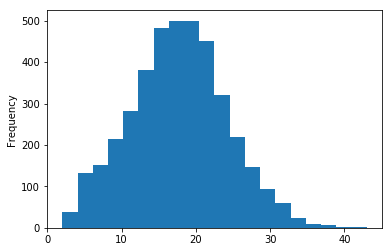

In [41]:
# Create a 'TDIFF' column that represents temperature difference
weather['TDIFF'] = weather['TMAX'] - weather['TMIN']

# Describe the 'TDIFF' column
print(weather['TDIFF'].describe())

# Create a histogram with 20 bins to visualize 'TDIFF'
weather.TDIFF.plot(kind='hist',bins=20)

The TDIFF column has no negative values and its distribution is approximately normal, both of which are signs that the data is trustworthy.

## 4.2 Categorizing the weather

The weather DataFrame contains 20 columns that start with 'WT', each of which represents a bad weather condition. For example:

WT05 indicates "Hail". 
WT11 indicates "High or damaging winds".
WT17 indicates "Freezing rain".

For every row in the dataset, each WT column contains either a 1 (meaning the condition was present that day) or NaN (meaning the condition was not present).

In this subsection, we'll quantify "how bad" the weather was each day by counting the number of 1 values in each row.

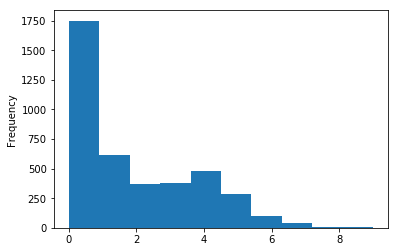

In [42]:
# Copy 'WT01' through 'WT22' to a new DataFrame
WT = weather.loc[:,'WT01':'WT22']

# Calculate the sum of each row in 'WT'
weather['bad_conditions'] = WT.sum(axis='columns')

# Replace missing values in 'bad_conditions' with '0'
weather['bad_conditions'] = weather.bad_conditions.fillna(0).astype('int')

# Create a histogram to visualize 'bad_conditions'
weather.bad_conditions.plot(kind='hist')

It looks like many days didn't have any bad weather conditions, and only a small portion of days had more than four bad weather conditions. Next, we'll use the counts to create a rating system for the weather.

The counts range from 0 to 9, and should be converted to ratings as follows:

Convert 0 to 'good'. 
Convert 1 through 4 to 'bad'.
Convert 5 through 9 to 'worse'. 

In [43]:
# Count the unique values in 'bad_conditions' and sort the index
# print(weather.bad_conditions.value_counts().sort_index())

# Create a dictionary that maps integers to strings
mapping = {0:'good', 1:'bad', 2:'bad', 3:'bad', 4:'bad', 5:'worse', 6:'worse', 7:'worse', 8:'worse', 9:'worse'}

# Convert the 'bad_conditions' integers to strings using the 'mapping'
weather['rating'] = weather.bad_conditions.map(mapping)

# Count the unique values in 'rating'
print(weather.rating.value_counts())

bad      1836
good     1749
worse     432
Name: rating, dtype: int64


In [44]:
# Create a list of weather ratings in logical order
cats = ['good','bad','worse']

# Change the data type of 'rating' to category
weather['rating'] = weather.rating.astype('category', categories=cats, ordered=True)

C:\Users\alexa\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """


## 4.3 Merging Datasets

Now that we've assigned a rating to the weather conditions each day, we need to merge that data with the traffic stop data so that we can analyze the relationship between weather and police behavior.

In [45]:
# As the index will be lost in the merge operation, we'll Reset the index of 'ri' to set the datetime information as a column
ri.reset_index(inplace=True)

# Examine the head of 'ri'
# print(ri.head())

# Create a DataFrame from the 'DATE' and 'rating' columns
weather_rating = weather[['DATE','rating']]

# Examine the head of 'weather_rating'
print(weather_rating.head())

         DATE rating
0  2005-01-01    bad
1  2005-01-02    bad
2  2005-01-03    bad
3  2005-01-04    bad
4  2005-01-05    bad


In [46]:
# Examine the shape of 'ri'
# print(ri.shape)

# Merge 'ri' and 'weather_rating' using a left join
ri_weather = pd.merge(left=ri, right=weather_rating, left_on='stop_date', right_on='DATE', how='left')

# Examine the shape of 'ri_weather'
# print(ri_weather.shape)

# Set 'stop_datetime' as the index of 'ri_weather'
ri_weather.set_index('stop_datetime', inplace=True)

## 4.4 Does weather affect the arrest rate?

Do police officers arrest drivers more often when the weather is bad? Find out below!

First, we'll calculate the overall arrest rate.

Then, we'll calculate the arrest rate for each of the weather ratings previously assigned.

Finally, we'll add violation type as a second factor in the analysis, to see if that accounts for any differences in the arrest rate.

In [47]:
# Calculate the overall arrest rate
print(ri_weather.is_arrested.mean())

0.0355690117407784


In [48]:
# Calculate the arrest rate for each 'rating'
print(ri_weather.groupby('rating').is_arrested.mean())

rating
good     0.033715
bad      0.036261
worse    0.041667
Name: is_arrested, dtype: float64


In [49]:
# Calculate the arrest rate for each 'violation' and 'rating'
print(ri_weather.groupby(['violation', 'rating']).is_arrested.mean())

violation            rating
Equipment            good      0.059007
                     bad       0.066311
                     worse     0.097357
Moving violation     good      0.056227
                     bad       0.058050
                     worse     0.065860
Other                good      0.076966
                     bad       0.087443
                     worse     0.062893
Registration/plates  good      0.081574
                     bad       0.098160
                     worse     0.115625
Seat belt            good      0.028587
                     bad       0.022493
                     worse     0.000000
Speeding             good      0.013405
                     bad       0.013314
                     worse     0.016886
Name: is_arrested, dtype: float64


The arrest rate increases as the weather gets worse, and that trend persists across many of the violation types. This doesn't prove a causal link, but it's quite an interesting result!

In [50]:
# Save the output of the groupby operation from the last exercise
arrest_rate = ri_weather.groupby(['violation', 'rating']).is_arrested.mean()

In [51]:
# Print the 'arrest_rate' Series
print(arrest_rate)

violation            rating
Equipment            good      0.059007
                     bad       0.066311
                     worse     0.097357
Moving violation     good      0.056227
                     bad       0.058050
                     worse     0.065860
Other                good      0.076966
                     bad       0.087443
                     worse     0.062893
Registration/plates  good      0.081574
                     bad       0.098160
                     worse     0.115625
Seat belt            good      0.028587
                     bad       0.022493
                     worse     0.000000
Speeding             good      0.013405
                     bad       0.013314
                     worse     0.016886
Name: is_arrested, dtype: float64


In [52]:
# Print the arrest rate for moving violations in bad weather
print(arrest_rate.loc['Moving violation','bad'])

0.05804964058049641


In [53]:
# Print the arrest rates for speeding violations in all three weather conditions
print(arrest_rate['Speeding'])

rating
good     0.013405
bad      0.013314
worse    0.016886
Name: is_arrested, dtype: float64


In [54]:
# Unstack the 'arrest_rate' Series into a DataFrame
print(ri_weather.pivot_table(index='violation', columns='rating', values='is_arrested'))

rating                   good       bad     worse
violation                                        
Equipment            0.059007  0.066311  0.097357
Moving violation     0.056227  0.058050  0.065860
Other                0.076966  0.087443  0.062893
Registration/plates  0.081574  0.098160  0.115625
Seat belt            0.028587  0.022493  0.000000
Speeding             0.013405  0.013314  0.016886


How curious, huh? It seems that the worse the weather the higher is the arrest rate. But be careful, correlation does not always means causation!

# 5. Final considerations

As you probably have guessed by the title of this section, this is the end of our journey. I hope you enjoyed it and this notebook provides you with many insights in your data explorer life. That's it for now, thank you and happy coding!